In [1]:
import requests
import os
import json
import pandas as pd
import numpy as np
import pickle as pkl
# import TwitterUtils as TU
import seaborn as sns
import re

# import spacy
# import spacy_langdetect as sld

In [2]:
!pip install tweepy

## Combining Data

The `GetPlaces.py`, `GetTweets.py`, and `SampleUser.py` files have generated the following output files:
* users.json : contains all the user specific data from the 51,000 sampled users
* places.pkl : metadata related to all twitter places in the user sample
* tweets.pkl : retrieved 100 tweets from each user

In [3]:
URL_regex = 'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&\/\/=]*)'
twitter_username_re = '(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)'
twitter_username_re = r"((^|[^@\w])@(\w{1,15})\b)*"

In [4]:
with open("places.pkl", "rb") as file: # Unique Places
    places = pkl.load(file)

with open('tweets.pkl', 'rb') as file: # Rename to Tweets, user_id, place_id
    data = pkl.load(file)

with open('users.json', 'r') as file: # Actual data for user accounts
    user_json = file.read()

test = '{"total": [' + user_json.replace("}{", "},{") + "]}"
user_data = json.loads(test)
users = [u['data'] for u in user_data["total"]]
flat_list = [user_id for user in users for user_id in user]

users_df = pd.DataFrame(flat_list).rename(columns = {'name' : 'user_name_field'})

In [5]:
places_unpacked = [item  for item in places.values()]
def unpack_place(place):
    return (place.id, place.name, place.full_name, place.country, place.country_code, place.place_type, place.centroid[0], place.centroid[1])

unpacked_places = [unpack_place(place) for place in places_unpacked]
place_df = pd.DataFrame(unpacked_places, columns = ("id", "name", "full_name", "country", "country_code", "type", "lat", "lon"))

In [7]:
place_df

,id,name,full_name,country,country_code,type,lat,lon
0,67b98f17fdcf20be,Boston,"Boston, MA",United States,US,city,-71.088478,42.311398
1,5c62ffb0f0f3479d,Phoenix,"Phoenix, AZ",United States,US,city,-112.073523,33.552088
2,8a927a7056322151,Botswana,Botswana,Botswana,BW,country,24.481179,-22.342707
3,06168d1feda43857,South East,"South East, England",United Kingdom,GB,admin,-0.993491,51.450970
4,94d47cc557aa35f4,Nicholasville,"Nicholasville, KY",United States,US,city,-84.579594,37.872506
...,...,...,...,...,...,...,...,...
7364,486bc865d347cd73,Florin,"Florin, CA",United States,US,city,-121.405325,38.489315
7365,35f73f0698fa5f98,Athens,"Athens, TN",United States,US,city,-84.603682,35.445604
7366,00ace66c41e736ad,Mubi,"Mubi, Nigeria",Nigeria,NG,city,13.269995,10.268770
7367,fb4d9b85c6daedc1,Nigel,"Nigel, South Africa",South Africa,ZA,city,28.464121,-26.390979


URL_regex = 'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'

In [6]:
URL_regex = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&\/\/=]*)'

In [7]:
df = pd.DataFrame(data)
merged = pd.merge(df, place_df, how = 'left', left_on = 'place_id', right_on='id')
full_data = pd.merge(merged, users_df, how='left', left_on ='user_id', right_on = 'id')

In [8]:
len(full_data['user_id'].unique())

30470

In [9]:
# Limit to top 6 countries
by_country = merged.groupby('country').count()
top6 = by_country.sort_values(by = 'user_id', ascending=False).head(6)
total = by_country.user_id.sum()
top6.user_id.divide(total).sum()

0.9066735266648764

The top 6 countries account for 91% of the total users collected, which suggests pretty good coverage. Dropping unnecessary columns

Rename Columns

In [10]:
target_fields = ['user_id', 'tweet_id', 'tweet_text', 'place_id', 'name',
       'full_name', 'country', 'country_code', 'type', 'username',
       'description', 'user_name_field', 'location', 'lat', 'lon']
reduced_df = full_data[target_fields]
reduced_df = reduced_df.rename(columns={'name':'place_name', 
                                        'full_name':'full_place_name',
                                        'type': 'place_type', 
                                        'description':'profile_description',
                                        'user_name_field':'profile_name',
                                        'location':'profile_location',
                                        'lat': 'lat',
                                        'lon':'lon'
                                        })

Drop Duplicates

In [11]:
top6_countries = top6.index
top6 = reduced_df[reduced_df['country'].isin(top6_countries)]
unique_tweets = top6['tweet_id'].unique()
top6 = top6.drop_duplicates('tweet_id')

## Clean Tweet Texts

In [15]:
def clean_text(text):
    temp = re.sub(URL_regex, "", text)

    return re.sub(twitter_username_re, "", text)

top6['clean_text'] = top6.tweet_text.apply(clean_text)

NameError: name 'spacy' is not defined

In [12]:
top6 = top6.drop_duplicates('tweet_id')
top6.shape

(859183, 15)

In [13]:
top6.to_csv('filtered_data.csv', index=False)

In [14]:
mapping = pd.read_csv('census_mapping.csv')

In [34]:
top6.columns

Index(['user_id', 'tweet_id', 'tweet_text', 'place_id', 'place_name',
       'full_place_name', 'country', 'country_code', 'place_type', 'username',
       'profile_description', 'profile_name', 'profile_location', 'lat', 'lon',
       'clean_text'],
      dtype='object')

In [15]:
cpl_list = top6[top6.country == 'United States'].to_dict('records')

for cpl in cpl_list:
    if cpl['place_type'] == 'city':
        cpl['state'] = cpl['full_place_name'][-2:].upper()
        if cpl['state'] not in set(mapping['State Code']):
            cpl['state'] = None
    elif cpl['place_type'] == 'admin':
        if cpl['place_name'] not in set(mapping.State):
            cpl['state'] = None
        else:
            cpl['state'] = mapping[mapping.State == cpl['place_name']]['State Code'].item()
    elif cpl['place_type'] == 'neighborhood': # Just Hollywood
        cpl['state'] = 'CA'
    else:
        cpl['state'] = None

    if cpl['state'] is not None:
        cpl['region'] = mapping[mapping['State Code'] == cpl['state']]['Region'].item()
        cpl['division'] = mapping[mapping['State Code'] == cpl['state']]['Division'].item()
    else:
        cpl['region'] = None
        cpl['division'] = None

In [19]:
test = pd.DataFrame(cpl_list)

In [20]:
test[['']]

,user_id,tweet_id,tweet_text,place_id,place_name,full_place_name,country,country_code,place_type,username,profile_description,profile_name,profile_location,lat,lon,state,region,division
0,2586324829,1637882537060999184,@hopefrtomorrow What I said about that is true...,9902fe95fc7596a7,Belvedere Park,"Belvedere Park, GA",United States,US,city,AmaBoukman1804,I am a moderate; the world is radically unjust...,Ama Boukman,United States,-84.259329,33.752877,GA,South,South Atlantic
1,2586324829,1637855927326892036,A test case doesn't have to include ALL variab...,9902fe95fc7596a7,Belvedere Park,"Belvedere Park, GA",United States,US,city,AmaBoukman1804,I am a moderate; the world is radically unjust...,Ama Boukman,United States,-84.259329,33.752877,GA,South,South Atlantic
2,2586324829,1637854618175565825,@desounds It would have to allow for multi-eth...,9902fe95fc7596a7,Belvedere Park,"Belvedere Park, GA",United States,US,city,AmaBoukman1804,I am a moderate; the world is radically unjust...,Ama Boukman,United States,-84.259329,33.752877,GA,South,South Atlantic
3,2586324829,1637854183956045838,@desounds Black people united in pursuit of po...,9902fe95fc7596a7,Belvedere Park,"Belvedere Park, GA",United States,US,city,AmaBoukman1804,I am a moderate; the world is radically unjust...,Ama Boukman,United States,-84.259329,33.752877,GA,South,South Atlantic
4,2586324829,1637852746597425164,@desounds What's good for the goose is good fo...,9902fe95fc7596a7,Belvedere Park,"Belvedere Park, GA",United States,US,city,AmaBoukman1804,I am a moderate; the world is radically unjust...,Ama Boukman,United States,-84.259329,33.752877,GA,South,South Atlantic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668912,51813432,1628119143546486785,@niicole__nicole @JRabbit951 Me!!! I love my n...,5c62ffb0f0f3479d,Phoenix,"Phoenix, AZ",United States,US,city,thariddler,Nice guys ALWAYS finish laaast...,Ramon Hernandez,"PHX, AZ",-112.073523,33.552088,AZ,West,Mountain
668913,51813432,1628114891633758210,@Intel_Dork My was the negotiator with Samuel ...,5c62ffb0f0f3479d,Phoenix,"Phoenix, AZ",United States,US,city,thariddler,Nice guys ALWAYS finish laaast...,Ramon Hernandez,"PHX, AZ",-112.073523,33.552088,AZ,West,Mountain
668914,51813432,1628113691555274752,"@DJCLUE From my top 5, I’d cry 😢",5c62ffb0f0f3479d,Phoenix,"Phoenix, AZ",United States,US,city,thariddler,Nice guys ALWAYS finish laaast...,Ramon Hernandez,"PHX, AZ",-112.073523,33.552088,AZ,West,Mountain
668915,51813432,1628113107108397056,@mobslittlemob I like to be a winner 😎🤙🏼😉😉😋👏🏼👏🏼👏🏼,5c62ffb0f0f3479d,Phoenix,"Phoenix, AZ",United States,US,city,thariddler,Nice guys ALWAYS finish laaast...,Ramon Hernandez,"PHX, AZ",-112.073523,33.552088,AZ,West,Mountain


In [21]:
cpl_us = pd.DataFrame(cpl_list).dropna(subset = ['state', 'region', 'division'])

In [22]:
cpl_us.shape

(667742, 18)

<AxesSubplot:ylabel='Frequency'>

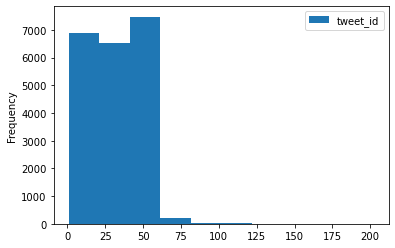

In [23]:
cpl_us.groupby('user_id').agg('count').reset_index().plot(x = 'user_id', y = 'tweet_id', kind = 'hist')

In [25]:
cpl_us.columns

Index(['user_id', 'tweet_id', 'tweet_text', 'place_id', 'place_name',
       'full_place_name', 'country', 'country_code', 'place_type', 'username',
       'profile_description', 'profile_name', 'profile_location', 'lat', 'lon',
       'state', 'region', 'division'],
      dtype='object')

In [28]:
grouped = cpl_us[['user_id', 'username', 'profile_description', 'lat', 'lon', 'state', 'region', 'division', 'tweet_text']].groupby(
    ['user_id', 'username', 'profile_description', 'lat', 'lon', 'state', 'region', 'division']
).agg(lambda x: ",".join(x)).reset_index()

In [29]:
grouped.to_csv('us_user_tweets.csv', index = False)

In [24]:
cpl_us.to_csv('tweets_us.csv', index = False)

In [ ]:
mapping = pd.read_csv('census_mapping.csv')

In [ ]:
cpl_list = top6[top6.country == 'United States'].to_dict('records')

for cpl in cpl_list:
    if cpl['place_type'] == 'city':
        cpl['state'] = cpl['full_place_name'][-2:].upper()
        if cpl['state'] not in set(mapping['State Code']):
            cpl['state'] = None
    elif cpl['place_type'] == 'admin':
        if cpl['place_name'] not in set(mapping.State):
            cpl['state'] = None
        else:
            cpl['state'] = mapping[mapping.State == cpl['place_name']]['State Code'].item()
    elif cpl['place_type'] == 'neighborhood': # Just Hollywood
        cpl['state'] = 'CA'
    else:
        cpl['state'] = None

    if cpl['state'] is not None:
        cpl['region'] = mapping[mapping['State Code'] == cpl['state']]['Region'].item()
        cpl['division'] = mapping[mapping['State Code'] == cpl['state']]['Division'].item()
    else:
        cpl['region'] = None
        cpl['division'] = None

In [ ]:
cpl_us = pd.DataFrame(cpl_list).dropna(subset = ['state', 'region', 'division'])
cpl_us.shape

In [ ]:
cpl_us.to_csv('tweets_us.csv', index = False)